[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/gray_SQ/gray_SQ_LloydMax.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/gray_SQ/gray_SQ_LloydMax.ipynb)


# Lloyd-Max Quantization

Use K-means to find the centroid of each bin. See [scikit-learn's Vector Quantization Example](https://scikit-learn.org/stable/auto_examples/cluster/plot_face_compress.html#sphx-glr-auto-examples-cluster-plot-face-compress-py).

Notice that the centroids must be transmitted to the decoder.

In [ ]:
!pip install Pygments

In [ ]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/scalar_quantization" ]; then
    cd $HOME/repos/scalar_quantization
    echo "$HOME/repos/scalar_quantization ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/scalar_quantization.git
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/MRVC" ]; then
    cd $HOME/repos/MRVC
    echo "$HOME/repos/MRVC ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/Sistemas-Multimedia/MRVC.git
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/image_IO" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/image_IO ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/information_theory" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/information_theory ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/information_theory.git
fi

In [ ]:
!ln -sf ~/MRVC/src/logging_config.py .
!ln -sf ~/repos/scalar_quantization/quantization.py .
!ln -sf ~/repos/scalar_quantization/deadzone_quantization.py .
!ln -sf ~/repos/scalar_quantization/LloydMax_quantization.py .
!ln -sf ~/repos/information_theory/distortion.py .
!ln -sf ~/repos/information_theory/information.py .
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/logging_config.py .

In [1]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    #plt.rcParams['text.usetex'] = True
    #plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
%matplotlib inline

try:
    import scipy
except:
    !pip install scipy
    
try:
    import cv2
except:
    !pip install opencv-python
    !pip install opencv-python-headless # Binder compatibility
    import cv2

try:
    import skimage
except:
    !pip install scikit-image
    import skimage
    
try:
    from sklearn import cluster
except:
    !pip install sklearn
    from sklearn import cluster

try:
    import colored
except:
    !pip install colored
    import colored

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
import deadzone_quantization as deadzone
import LloydMax_quantization as quantization
import distortion
#import image_3 as RGB_image
import image_1 as gray_image
import colored
import information

/home/vruiz/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Configuration

In [2]:
home = os.environ["HOME"]
fn = home + "/repos/MRVC/images/lena_bw/"
!ls -l {fn}

quantizer = quantization.LloydMax_Quantizer

n_clusters = 4  # Number of bins
N_tries = 4  # Number of times K-means is run
#N_bins = range(2, 128, 1)
N_bins = [2, 4, 8, 16, 32, 64, 128] #range(2, 128, 1)
gray_image.write = gray_image.debug_write # faster
#gray_image.write = gray_image.write # higher compression

total 148
-rw-r--r-- 1 vruiz vruiz 151199 feb 18 22:33 000.png


## Read the image and show it

[image_1.py:69 print_stats() INFO] /home/vruiz/repos/MRVC/images/lena_bw/000.png max=245 min=25 avg=124.05046081542969


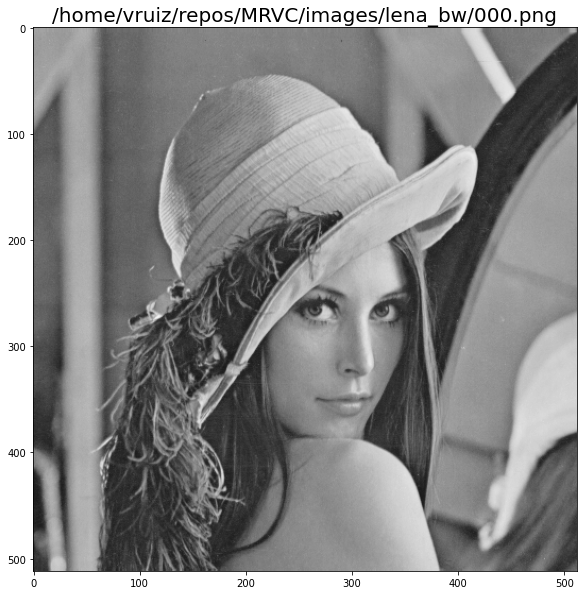

In [3]:
img = gray_image.read(fn, 0)
gray_image.show(img, fn + "000.png")

## Lloyd-Max quantization using K-means

In [ ]:
!pygmentize quantization.py

In [ ]:
!pygmentize LloydMax_quantization.py

## Example

In [4]:
QSS = 32 # Quantization Step Size

In [5]:
Q = quantizer(img, Q_step=QSS, min_val=0, max_val=255)
print("decision_levels =", Q.get_decision_levels())
print("representation_levels =", Q.get_representation_levels())

/home/vruiz/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


decision_levels = [  0  59  84 109 131 149 169 193 255]
representation_levels = [ 47.99065177  71.88186468  98.10032899 121.84709241 140.77099295
 158.1160013  180.06251408 206.30581416]


In [6]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

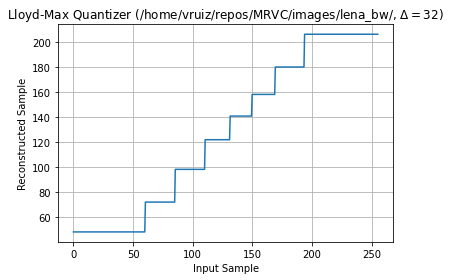

In [8]:
X = np.linspace(0, 255, 500) # Input samples
Y, K = Q.quan_dequan(X)
plot(X, Y, "Input Sample", "Reconstructed Sample", f"Lloyd-Max Quantizer ({fn}, $\Delta={QSS}$)")

Neither, the decision levels nor the representation levels are equally spaced. This is a direct consequence of the PDF of the input image. Thus, those input ranges where the number of gray-tones are more frequent, the resolution of the quantizer is increased. The representation levels are placed where the MSE is minimized.

In [ ]:
y, k = Q.quan_dequan(img)
print("Used quantization indexes:", np.unique(k))
gray_image.show_normalized(k, f"Quantization Indexes ($\\Delta={QSS}$)")
gray_image.show(y, f"Dequantized Image ($\\Delta={QSS}$)")
print("MSE =", distortion.MSE(img, y))
print("SSIM =", distortion.SSIM(img, y))
print("entropy =", information.entropy(k.flatten()))

## RD curve
We compare two versions:
1. When the centroids are initialized using an scalar quantizer.
2. When the centroids are initialized at random.

In [ ]:
def RD_curve2(img, N_bins):
    points = []
    flatten_img = img.reshape((-1, 1))  # flatten
    for n in N_bins:
        k_means = cluster.KMeans(n_clusters=n, n_init=N_tries)
        k_means.fit(flatten_img)
        centroids = k_means.cluster_centers_.squeeze().astype(np.uint8)  # Centroids
        k = k_means.labels_.astype(np.uint8)  # Labels of the centroids
        #y = np.choose(k, centroids)
        #y = centroids[k[range(len(k))]]
        y = centroids[k]
        y.shape = img.shape
        k.shape = img.shape
        print("Quantization indexes: ", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(K.shape[0]*K.shape[1])
        _distortion = distortion.RMSE(img, y)
        if n<16:
            plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
            plt.show()
        points.append((rate, _distortion))
        print(f"n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

def RD_curve(img, N_bins):
    points = []
    for n in N_bins:
        QS = 256//n
        Q = quantizer(img, Q_step=QS, min_val=0, max_val=255)
        y, k = Q.quan_dequan(img)
        print("Quantization indexes: ", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(K.shape[0]*K.shape[1])
        _distortion = distortion.RMSE(img, y)
        if n<16:
            plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
            plt.show()
        points.append((rate, _distortion))
        print(f"n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RD_points = RD_curve(img, N_bins)
RD_points2 = RD_curve2(img, N_bins)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker='x', label=f"Using sorted labels", linestyle="dotted")
pylab.plot(*zip(*RD_points2), c='b', marker='x', label=f"Using unsorted labels", linestyle="dotted")
pylab.title(f"Rate/Distortion Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

It is more RD-efficient (and faster, because K-Means only runs one time) to initialize the centroids.

In [ ]:
with open(f"LloydMax_RD_points.txt", 'w') as f:
    for item in RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

## What happens if we increase the granuality?
Let's see the effect of using a finer quantization step (size).

In [ ]:
N_bins = [i for i in range(2, 128, 1)]
print(N_bins)

In [ ]:
def _(a, cmap, vmin, vmax):
    pass
plt.show = print
plt.imshow = _
RD_points_finer = RD_curve(img, N_bins)

In [ ]:
len(RD_points_finer)

In [ ]:
RD_points_finer

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker='x', label=f"Using powers of 2", linestyle="dotted")
pylab.plot(*zip(*RD_points_finer), c='g', marker='.', label=f"Using more quantization steps", linestyle="dotted")
pylab.title(fn)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

As it can be seen:

1. The use of quantization steps that are not powers of 2 can generate some cases in which when we decrease the step, the rate increases.
2. The quantization steps that are powers of 2 are reasonably close to the convex hull of the RD curve (all the points contributes to the convexity of the curve).

## RDO (Rate Distortion Optimization)
It is posible to improve the RD curve using stocastic search. The idea is to, given a K-Means solution, perform a number of iterations of the classifier with the hope of finding a better one (remember that K-Means obtains different solutions when it is run several times). If this happens, the process is repeated. Otherwise, we stop.

To determine if the current classifier is better than the previous one, we can use a Lagrangian Multiplier
$$
J = D+\lambda R,
$$
where the tradeoff between rate (R) and distortion (D) is quantified for a given slope $\lambda$. Thus, the smaller the $J$, the better the classifier.

In [ ]:
def RDO(img, N_bins, Q_step, max_number_of_iters, prev_Q, _lambda):
    curr_Q = prev_Q
    for i in range(max_number_of_iters):
        Y, K = curr_Q.quan_dequan(img)
        R = gray_image.write(K, "/tmp/" + str(n) + '_', 0)*8/(K.shape[0]*K.shape[1])
        D = distortion.RMSE(img, Y)
        curr_J = D + _lambda * R
        next_Q = quantizer(img, Q_step, min_val=0, max_val=255)
        

In [ ]:
import time
while True:
    time.sleep(1)

## Ignore the rest ...

In [ ]:
np.random.seed(0)  # makes the random numbers predictable
flatten_img = img.reshape((-1, 1))  # flatten
k_means = cluster.KMeans(n_clusters=n_clusters, n_init=N_tries)
k_means.fit(flatten_img)  # train
centroids = k_means.cluster_centers_.squeeze()  # Centroids
print("centroids =", centroids)
labels = k_means.labels_  # Labels of the centroids
labels.shape = img.shape
print(len(labels), len(centroids), img.shape, n_clusters, len(centroids.flatten()))
gray_image.show_normalized(labels, "Labels")

Notice that the indexes (labels) are not sorted by the corresponding intensity values.

In [ ]:
# create an array from labels and values
#img_dequantized = np.choose(labels, centroids)
#img_dequantized = centroids[range(len(labels)), labels]
#img_dequantized = np.empty_like(flatten_img)
#for i in range(len(labels)):
#    img_dequantized[i] = centroids[labels[i]]
#img_dequantized = centroids[labels[range(len(labels))]]
img_dequantized = centroids[labels]
#img_dequantized.shape = img.shape

print("labels", labels, labels.shape)
print("max and min dequantized image", img_dequantized.max(), img_dequantized.min())
prediction = k_means.predict(flatten_img)  # Quantize
prediction.shape = img.shape
print("prediction =", prediction)
print("prediction.shape =", prediction.shape)

vmin = img.min()
vmax = img.max()

gray_image.show(img_dequantized, "Dequantized")
new_img_dequantized = centroids[prediction]
gray_image.show(new_img_dequantized, "New Dequantized")